This notebook fits the diffraction geometry + module geometry to a series of powder patterns (with different beam centers)

In [1]:
import time
start = time.time()
import pylab as pl, numpy as np, os
from ImageD11 import transform
from ImageD11.transformer import transformer
from ImageD11.parameters import read_par_file
from ImageD11.columnfile import columnfile
import h5py
import scipy.optimize
import fabio
%matplotlib inline

In [2]:
12.3985/55 # keV : approximate wavelength

0.22542727272727273

In [3]:
# The par files need to be manually created ... ?
#  ... done in ImageD11_gui.py
#
# ... then all iterated using fitted parameters as a starting point
for i in range(1,5):
    # initial 
    p = read_par_file("eigerSpatial/%d.par"%(i))
#    p = read_par_file("eigerSpatial/%ds.par"%(i)) # s = spatial
    print(i,p.get('y_center'),p.get('z_center'))

1 1058.53500358 1127.26651867
2 1991.00172344 1129.0805125
3 1989.19079703 1595.21446251
4 1083.36206289 1593.55779584


In [4]:
frms = [1,2,3,4]

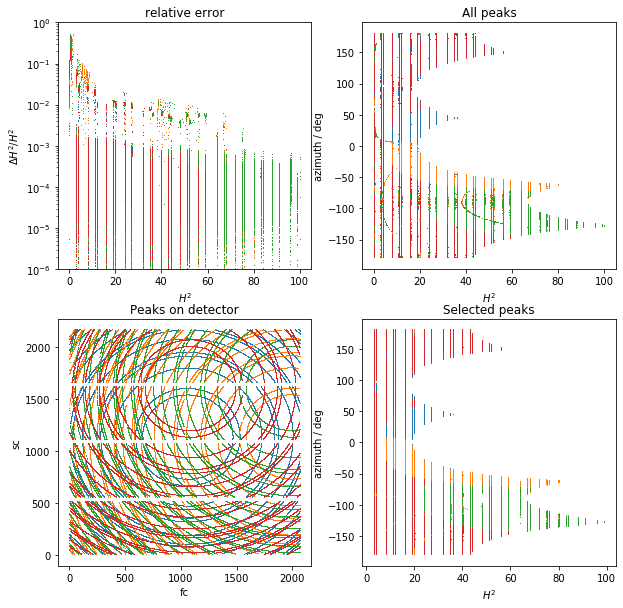

In [5]:
# created via moduleSpatialPeakSearch
f, ((a3, a4),(a1,a2)) = pl.subplots(2,2,figsize=(10,10))
cf = {}
a0 = 5.411
ds0 = a0*a0
for i in frms:
    # Load the peaks and parameters:
    c = columnfile( 'eigerSpatial/%d.flt'%(i) )
    c.parameters.loadparameters('eigerSpatial/%d.par'%(i) )
    c.updateGeometry()
    # Create column of frame number
    c.addcolumn(np.ones(c.nrows)*i,'frame')
    # (d*_obs)^2 / (a_0)^2 from cubic hkl to d-spacing formula
    c.addcolumn(np.ones(c.nrows)*c.ds**2*ds0,'hkl2')
    # nearest integers == fit target values
    c.addcolumn(np.round(c.hkl2),'ihkl2')
    # something like a strain
    se = abs( c.ihkl2 - c.hkl2 )/np.where( c.ihkl2 > 0, c.ihkl2, 1)
    a3.plot(c.hkl2, se, ",")
    a4.plot(c.hkl2, c.eta, ",")
    c.filter((c.Number_of_pixels>7) & (c.ihkl2>2) &  (se<2e-3) )
    a1.plot(c.fc,c.sc,',')
    a2.plot(c.hkl2,c.eta,',')
    cf[i] = c
a1.set(title='Peaks on detector', ylabel='sc', xlabel='fc')
a2.set(title='Selected peaks', ylabel='azimuth / deg', xlabel='$H^2$')
a3.set(yscale='log', ylim=(1e-6,1), title='relative error', ylabel='$\Delta H^2/H^2$', xlabel='$H^2$')
_ = a4.set(title='All peaks', ylabel='azimuth / deg', xlabel='$H^2$')


In [6]:
# put together all of the peaks:
allpks = np.concatenate( [cf[f].bigarray for f in frms], axis=1)
# ... and place them into an ImageD11 colummfile object
allc = c.copy()
allc.set_bigarray(allpks)
allc.nrows, np.sum([cf[f].nrows for f in frms])

(227444, 227444)

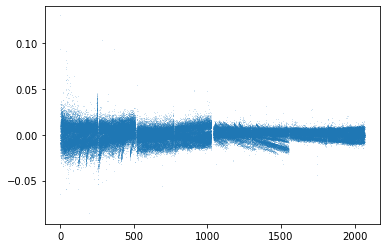

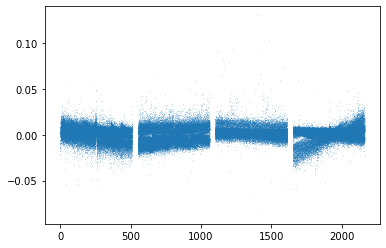

In [7]:
# Remove "bad" peaks from virtual shared pixels
for col in 255.5, 513.5, 771.5, 1295.5, 1553.5, 1811.5:
    allc.filter(abs(allc.fc-col)>2.1)
for row in 255.5, 805.5, 1355.5, 1905.5:
    allc.filter(abs(allc.sc-row)>2.1)
pl.figure(2)
pl.plot(allc.fc,allc.ihkl2-allc.hkl2, ',', alpha=0.2)
pl.figure(3)
pl.plot(allc.sc,allc.ihkl2-allc.hkl2, ',', alpha=0.2)

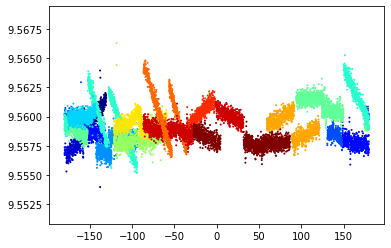

In [8]:
# just one ring, color by module
pl.figure(4)
m = allc.ihkl2 == 16
pl.scatter(allc.eta[m],allc.tth[m],c=allc.module[m], s = 1, cmap = 'jet')

In [9]:
frm = np.unique(allc.frame)
modu = np.unique(allc.module)
print(frm, modu)

[1. 2. 3. 4.] [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


In [10]:
# set up a fitting problem : these parameters will be fed to the calchkl2 routine below

# distance, tilts, centers for each image 
pars = [ ]
pnames = [ ]
for f in frm:
    pars.append( cf[f].parameters.get('distance') / a0 ) # distance scaled on lattice
    pnames.append( '%d:distance/a'%(f) )
    for pname in 'y_center z_center tilt_y tilt_z'.split():
        pars.append( cf[f].parameters.get(pname) )
        pnames.append( '%d:%s'%(f, pname) )

pars.append( a0 ) # effectively the wavelength
pnames.append( 'a0' )
framepars = len(pars)
nframes = len(cf.keys())
pars += [0. for i in range(15*3)] # 16 module centers and tilts, BUT LAST IS FIXED
pnames += ["M[%d,%d]"%(i,j) for i in range(15) for j in range(3) ]
for n,v in zip(pnames, pars):
    print(n,v)
# offset, rotation for each module

1:distance/a 77.70467880558122
1:y_center 1058.53500358
1:z_center 1127.26651867
1:tilt_y -0.00160686467111
1:tilt_z 0.000325718756829
2:distance/a 77.71738108076141
2:y_center 1991.00172344
2:z_center 1129.0805125
2:tilt_y -0.00143449617676
2:tilt_z 0.00216685013957
3:distance/a 77.75348638495657
3:y_center 1989.19079703
3:z_center 1595.21446251
3:tilt_y -0.00143790339812
3:tilt_z 0.00224047835849
4:distance/a 77.7422864806875
4:y_center 1083.36206289
4:z_center 1593.55779584
4:tilt_y -0.00118993655588
4:tilt_z 0.000900844757526
a0 5.411
M[0,0] 0.0
M[0,1] 0.0
M[0,2] 0.0
M[1,0] 0.0
M[1,1] 0.0
M[1,2] 0.0
M[2,0] 0.0
M[2,1] 0.0
M[2,2] 0.0
M[3,0] 0.0
M[3,1] 0.0
M[3,2] 0.0
M[4,0] 0.0
M[4,1] 0.0
M[4,2] 0.0
M[5,0] 0.0
M[5,1] 0.0
M[5,2] 0.0
M[6,0] 0.0
M[6,1] 0.0
M[6,2] 0.0
M[7,0] 0.0
M[7,1] 0.0
M[7,2] 0.0
M[8,0] 0.0
M[8,1] 0.0
M[8,2] 0.0
M[9,0] 0.0
M[9,1] 0.0
M[9,2] 0.0
M[10,0] 0.0
M[10,1] 0.0
M[10,2] 0.0
M[11,0] 0.0
M[11,1] 0.0
M[11,2] 0.0
M[12,0] 0.0
M[12,1] 0.0
M[12,2] 0.0
M[13,0] 0.0
M[13,

In [11]:
def module(a,i,j):
    #p = padding around the outside for debug
    fs = 513
    ss = 512
    fo = [0,2,14,16]
    so = [0,38,2*38,38*3]
    f = fs*j + fo[j]
    s = ss*i + so[i]
    return a[s:s+ss,f:f+fs]

def module_center( i, j ):
    fs = 513
    ss = 512
    fo = np.array([0,2,14,16])
    so = np.array([0,38,2*38,38*3])
    # print(i.dtype,j.dtype,j.shape)
    return so[i] + ss*(i+0.5), fo[j] + fs*(j+0.5)

def mp15_16( p15 ):
    """ Compute the parameters of module 16 from the other 15 
    We set the sum of all 16 to be zero
    """
    p16 = np.array(list(p15) + [0,0,0]).reshape( (16, 3) ) 
    p16[-1,:] = -np.sum(p16, axis=0) # last module is fixed to make mean zero
    return p16
    
    
def do_spatial(s_raw, f_raw, m, modpars):
    """
    s_raw = co-ordinate in the slow pixel direction
    f_raw = co-ordinate in the fast pixel direction
    m = module for this peak (in the range 0,15 for Eiger4M)
    modpars = spatial parameters (offset_slow, offset_fast, angle_rad)
    """
    i = m // 4
    j = m % 4
    cs, cf = module_center( i, j )
    shift_s = np.array( modpars[:,0] )
    shift_f = np.array( modpars[:,1] )
    ds = s_raw[:] - cs + shift_s[m]
    df = f_raw[:] - cf + shift_f[m]
    rotates = modpars[:,2]
    sinr = np.sin(rotates)
    cosr = np.cos(rotates)
    dsr =  cosr[m] * ds  + sinr[m] * df
    dfr = -sinr[m] * ds  + cosr[m] * df
    sc = dsr + cs
    fc = dfr + cf
    return sc,fc    

def calchkl2( colf, *args ):
    """
    colf = columnfile (table) containing labelled peaks
    *args = parameters to be fitted
    """
    fpars = np.array(list(args))
    global framepars, frm # above
    modpars = mp15_16(fpars[framepars:]) # make last module == sum of previous
    #
    ycalc = np.zeros(colf.nrows, float)
    # apply the current spatial correction
    m = colf.module[:].astype(int)
    sc, fc = do_spatial( colf.s_raw, colf.f_raw, m, modpars )
    e = 55
    w = 12.3985/e
    a0 = fpars[framepars-1]
    for k,rf in enumerate(frm):
        f = int(rf)
        lo = np.searchsorted( colf.frame, f )   # assume data still sorted by frame
        hi = np.searchsorted( colf.frame, f+1 )
        # compute x,y,z laboratory
        x,y,z = transform.compute_xyz_lab( (sc[lo:hi], fc[lo:hi]), 
                                               distance = fpars[k*5]*a0, # take out ds0 again
                                               y_center = fpars[k*5+1],
                                               z_center = fpars[k*5+2],
                                               y_size=0.075, z_size=0.075,
                                               tilt_y = fpars[k*5+3],
                                               tilt_z = fpars[k*5+4],
                                               tilt_x = 0,
                                               o11=1,o12=0,o21=0,o22=-1 )
        # radius:
        r = np.sqrt(y*y + z*z)
        # two theta:
        tthrad = np.arctan2(r, x)
        # wvln = 2*d*sin(th)
        # 1/d = 2*sin(th)/wvln
        # c.ds**2*ds0
        ds = 2*np.sin( tthrad/2 ) / w
        ycalc[lo:hi] = ds*ds*a0*a0
    scor = np.mean((ycalc - colf.ihkl2)**2)
    strain = (ycalc - colf.ihkl2)/colf.ihkl2  # approximately zero
    return strain

[]

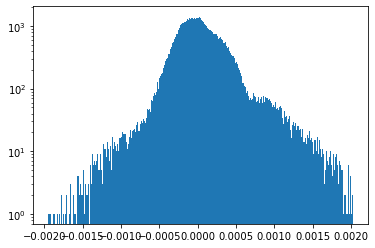

In [12]:
yc = calchkl2( allc, *pars )
pl.figure()
pl.hist(yc,bins=1024)
pl.semilogy()

In [13]:
avgi = allc.sum_intensity / allc.Number_of_pixels   # average intensity in a peak 
sigma = avgi/avgi.max()                             # relative weights

fpars, matrx = scipy.optimize.curve_fit( calchkl2,               # function to fit
                               allc,                    # 'x' argument to function 
                               np.zeros(allc.nrows),    # y_obs values (integer hkls)  
                               pars,                    # parameters to be fitted
                               sigma = sigma  )

Correlation above 80%
3:tilt_z 2:tilt_z 0.948390179815983
4:distance/a 1:distance/a 0.8424094412130543
a0 2:tilt_z -0.8609586847108591
a0 3:tilt_z -0.8600584793258843
M[8,1] 1:distance/a -0.8373879786900826


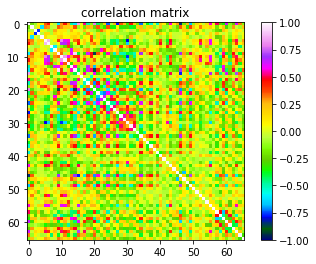

In [14]:
#print(fpars, matrx)
pl.figure()
corr = matrx.copy()
ser = np.sqrt(np.diag(corr))
corr = corr / ser 
corr = corr.T / ser
pl.imshow(corr, cmap='gist_ncar', vmin=-1)
pl.colorbar()
pl.title("correlation matrix")
print("Correlation above 80%")
for i in range(corr.shape[0]):
    for j in range(i-1):
        if abs(corr[i,j])>0.8:
            print(pnames[i],pnames[j],corr[i,j])

[]

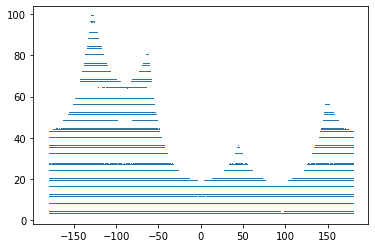

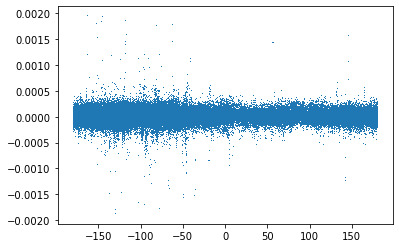

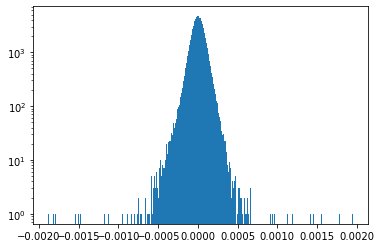

In [15]:
ycalc = calchkl2(allc, *fpars)
pl.figure()
pl.plot(allc.eta, ycalc*allc.ihkl2+allc.ihkl2, ",")
pl.figure()
pl.plot(allc.eta, ycalc, ",")
pl.figure()
pl.hist( ycalc, bins=1024)
pl.semilogy()

In [16]:
allc.filter( abs(ycalc)<0.0003 )

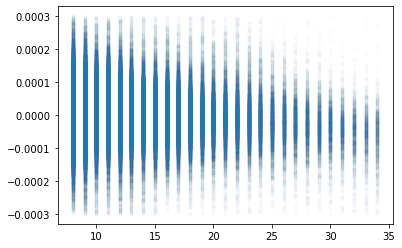

In [17]:
ycalc = calchkl2(allc, *fpars)
pl.figure()
pl.plot(allc.Number_of_pixels,ycalc,'.', alpha=0.01)

In [18]:
# repeat fitting with cleaned data
p2 = [p for p in fpars]  
fpars2, matrx2 = scipy.optimize.curve_fit( calchkl2, allc, np.zeros(allc.nrows), p2 )

In [19]:
p16 = mp15_16(fpars2[framepars:])

In [20]:
np.savetxt("fitted_eiger_pars2.dat",fpars2)
np.savetxt("fitted_eiger_framepars2.dat",p16)

In [21]:
# Write spatially corrected files
a0 = fpars2[framepars-1]
for i in range(1,5):
    p = read_par_file("eigerSpatial/%d.par"%(i))
    k = i-1
    p.parameters.update( {'distance' : fpars2[k*5]*a0,
                          'y_center' : fpars2[k*5+1],
                          'z_center' : fpars2[k*5+2],
                          'tilt_y' : fpars2[k*5+3],
                          'tilt_z' : fpars2[k*5+4] } )
    p.saveparameters("eigerSpatial/%ds.par"%(i))

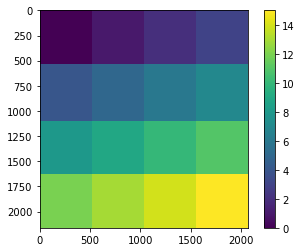

In [22]:
# Verify and create conventional distortion files
s, f = np.mgrid[0:2162,0:2068]
m = np.zeros(s.shape, np.int)-1
#    fs = 513
#    ss = 512
#    fo = [0,2,14,16]
#    so = [0,38,2*38,38*3]
for i in range(4):
    for j in range(4):
        a = module(m,i,j)
        a[:,:] = i*4+j
# Make an image of which module is this pixel
# fill gaps: ... yes, this could be more elegant
m[512:512+38//2,:]=m[511,:]
m[512+38//2:512+38,:]=m[512+39,:]
m[512*2+38:512*2+38+38//2,:]=m[512*2+38-1,:]
m[512*2+38+38//2:512*2+38*2,:]=m[512*2+2+38+1,:]
m[512*3+38*2:512*3+38*2+38//2,:]=m[512*3+38*2-1,:]
m[512*3+38*2+38//2:512*3+38*3,:]=m[512*3+3*38+1,:]
m[:,513]=m[:,512]
m[:,514]=m[:,515]
m[:,-514]=m[:,-513]
m[:,-515]=m[:,-516]
m[:,1027:1034]=m[:,1025][:,np.newaxis]
m[:,1034:1040]=m[:,1041][:,np.newaxis]
# verify we did not mess up the real pixels:
for i in range(4):
    for j in range(4):
        a = module(m,i,j)
        assert((a[:,:] == i*4+j).all())
pl.figure()
pl.imshow(m)
pl.colorbar()

In [23]:
# full image spatial:
sc,fc = do_spatial(s.ravel(),f.ravel(),m.ravel(), p16)
sc.shape=s.shape
fc.shape=f.shape
ds = sc - s      # LUT
df = fc - f      # 

In [24]:
fabio.edfimage.edfimage((fc-f).astype(np.float32)).write("e2dx.edf")
fabio.edfimage.edfimage((sc-s).astype(np.float32)).write("e2dy.edf")

In [25]:
# convert this spatial distortion in pyFAI format - original file came from J. Kieffer grid fit.
pyFAIspatial = "/data/id11/nanoscope/Eiger/Eiger2CdTe_4M_ID11.h5"
with h5py.File(pyFAIspatial,'r') as h:
    x = h['entry_0000/pyFAI/Eiger2_CdTe_4M/pixel_corners'][:]
    print(x.shape, x[-1,-1])

(2162, 2068, 4, 3) [[0.         0.16209182 0.15504065]
 [0.         0.16216682 0.15504071]
 [0.         0.16216677 0.15511571]
 [0.         0.16209178 0.15511565]]


In [26]:
os.system('cp ' + pyFAIspatial + ' newSpatial.h5' )

0

In [27]:
ps = 7.5e-5
with h5py.File('newSpatial.h5','r+') as h:
    x = h['entry_0000/pyFAI/Eiger2_CdTe_4M/pixel_corners'][:]
    sc,fc = do_spatial(s.ravel()-0.5,f.ravel()-0.5,m.ravel(), p16)
    sc=np.reshape(sc,s.shape)
    fc=np.reshape(fc,f.shape)
    x[:,:,0,1] = sc*ps
    x[:,:,0,2] = fc*ps

    sc,fc = do_spatial(s.ravel()+0.5,f.ravel()-0.5,m.ravel(), p16)
    sc=np.reshape(sc,s.shape)
    fc=np.reshape(fc,f.shape)
    x[:,:,1,1] = sc*ps
    x[:,:,1,2] = fc*ps

    sc,fc = do_spatial(s.ravel()+0.5,f.ravel()+0.5,m.ravel(), p16)
    sc=np.reshape(sc,s.shape)
    fc=np.reshape(fc,f.shape)
    x[:,:,2,1] = sc*ps
    x[:,:,2,2] = fc*ps

    sc,fc = do_spatial(s.ravel()-0.5,f.ravel()+0.5,m.ravel(), p16)
    sc=np.reshape(sc,s.shape)
    fc=np.reshape(fc,f.shape)
    x[:,:,3,1] = sc*ps
    x[:,:,3,2] = fc*ps
    h['entry_0000/pyFAI/Eiger2_CdTe_4M/pixel_corners'][:]=x

In [28]:
t = transformer()
t.loadfiltered("eigerSpatial/1.flt")
c = t.colfile
c.sc[:] = ds[np.round( c.s_raw[:].astype(int) ), np.round( c.f_raw[:].astype(int) ) ] + c.s_raw[:]
c.fc[:] = df[np.round( c.s_raw[:].astype(int) ), np.round( c.f_raw[:].astype(int) ) ] + c.f_raw[:]
t.loadfileparameters("eigerSpatial/1s.par")
t.compute_tth_eta()
t.addcellpeaks()
t.parameterobj.varylist.append('wavelength')
t.fit()

Tolerance for assigning peaks to rings 0.025 , min tth 0.0 , max tth 180.0
Iteration = 105   Best = 15.251641   Worst = 15.251918                                        [1127.4313970971164, 1058.770505829506, 420.36555544677867, -0.010269012838816465, -0.006711344111369753, 0.2255656201388527]


In [29]:
t.fit_tolerance=0.005
for i in range(3):
    t.addcellpeaks() 
    t.fit()
    t.compute_tth_eta()
t.addcellpeaks() # wavelenght is fitted

Tolerance for assigning peaks to rings 0.025 , min tth 0.0 , max tth 180.0
Iteration = 37   Best = 0.720309   Worst = 0.720609                                 [1127.259747284168, 1058.3753243876686, 420.26923264066863, 0.0010967349317360616, -0.0015433053151248139, 0.2255699960770794]
Tolerance for assigning peaks to rings 0.025 , min tth 0.0 , max tth 180.0
Iteration = 49   Best = 0.598895   Worst = 0.599159                          [1127.2446199383648, 1058.358767215591, 420.264468326322, 0.0012417579148268597, -0.0014194796352748327, 0.22557076988927718]
Tolerance for assigning peaks to rings 0.025 , min tth 0.0 , max tth 180.0
Iteration = 38   Best = 0.400262   Worst = 0.400457                                [1127.261081386457, 1058.369805105358, 422.3110442782913, 0.0011519296324089688, -0.0015646820209073626, 0.22450544325122007]


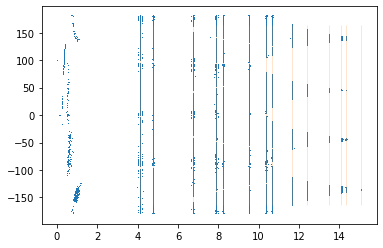

In [30]:
pl.figure()
pl.plot(t.colfile.tth,t.colfile.eta,",")
pl.plot(t.theorytth,np.zeros(len(t.theorytth)),"|",ms=180,alpha=0.2)

In [31]:
12.3985/t.parameterobj.parameters['wavelength']

55.22583248071256

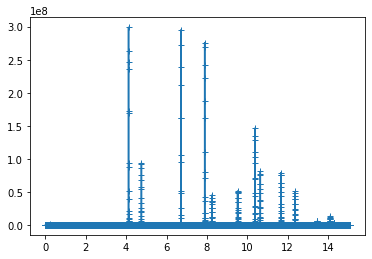

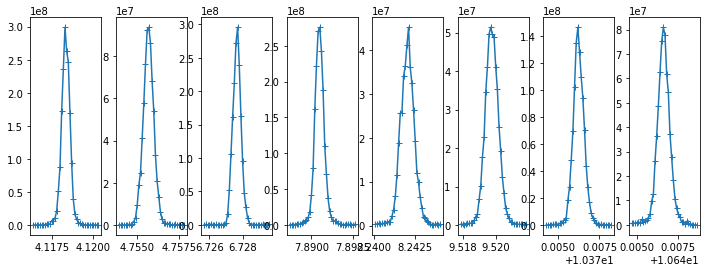

In [32]:
h,b = np.histogram(c.tth,weights=c.sum_intensity,bins=np.arange(0,c.tth.max(),0.0001))
pl.figure()
pl.plot(b[1:],h,'+-')
f,a=pl.subplots(1,8,figsize=(12,4))
for i,tth in enumerate(t.theorytth[:8]):
    lo = np.searchsorted(b,tth-0.002)
    hi = np.searchsorted(b,tth+0.002)
    a[i].plot( b[lo:hi], h[lo:hi], "+-" )

In [33]:
c.parameters = t.parameterobj

In [34]:
c.updateGeometry()

tth   npks    rad_mean    rad_std    Median_abs_dev  Mean_abs_dev
4.11838  2395 404.744 0.020 0.015 0.017
4.75583  3202 467.381 0.026 0.018 0.021
6.72770  3731 661.179 0.020 0.014 0.017
7.89063  4673 775.458 0.022 0.016 0.018
8.24209  5508 810.010 0.035 0.025 0.029
9.51988  6518 935.581 0.034 0.025 0.028
10.37630  6314 1019.752 0.027 0.019 0.022
10.64663  5888 1046.323 0.031 0.022 0.025
11.66616  4000 1146.518 0.029 0.021 0.024
12.37652  3026 1216.329 0.030 0.021 0.024
13.47873  1598 1324.652 0.045 0.033 0.037
14.09946   813 1385.651 0.031 0.022 0.025
14.30050   592 1405.408 0.042 0.030 0.034
15.07842    66 1481.866 0.046 0.035 0.038


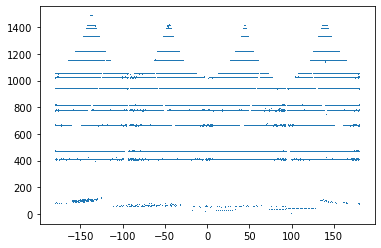

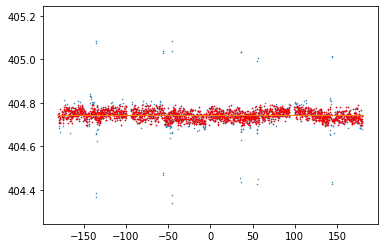

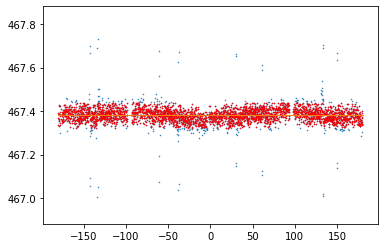

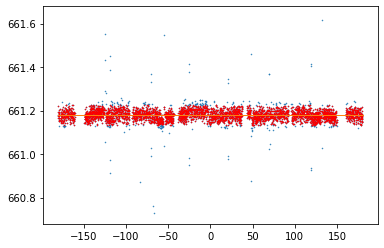

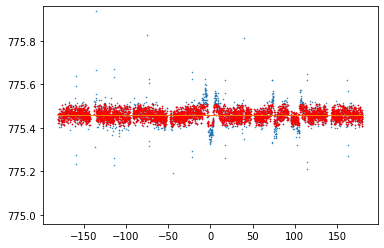

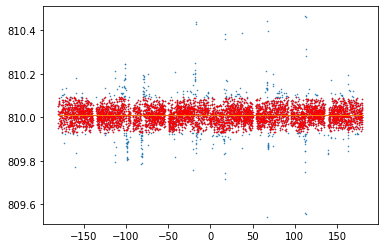

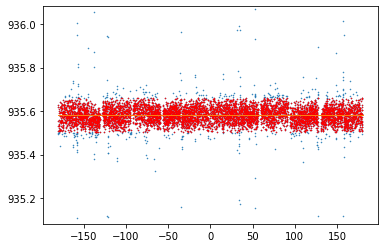

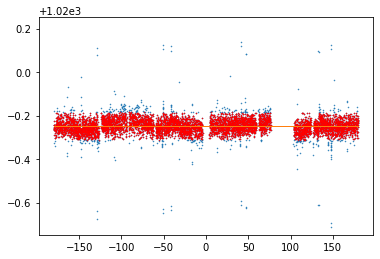

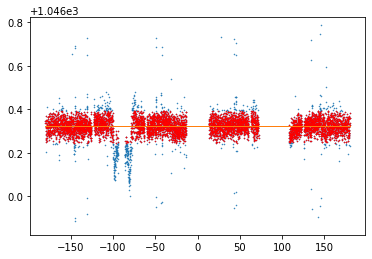

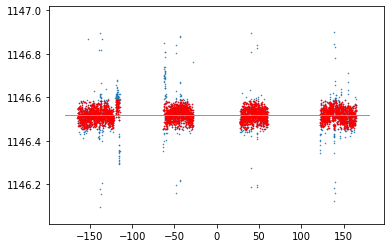

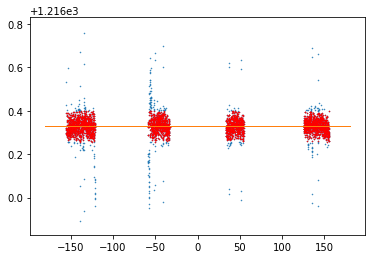

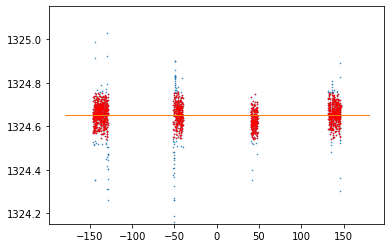

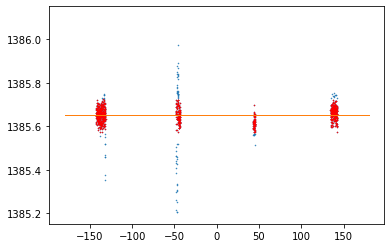

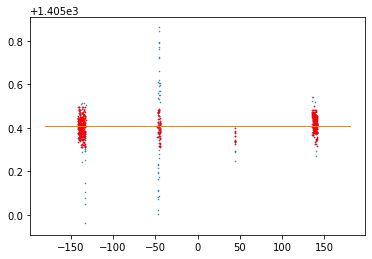

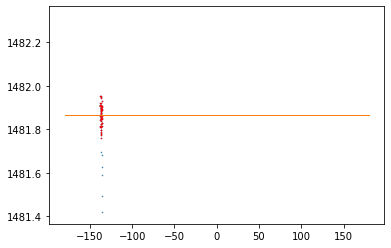

In [35]:
c.titles
r = np.arctan2(np.sqrt(c.yl*c.yl+c.zl*c.zl), c.xl)*c.xl.mean()/0.075
pl.figure()
pl.plot(c.eta,r,",")
rcalc = np.zeros(r.shape,np.float)
lines = ["tth   npks    rad_mean    rad_std    Median_abs_dev  Mean_abs_dev",]
for tth in t.theorytth:
    sel = np.abs(c.tth - tth)<0.005
    pks = r[sel]
    if sel.sum()==0:
        continue
    rc = pks.mean()
    mad = np.median(abs(r[sel] - rc))
    msel = np.abs( r - rc ) < mad * 3
    pks = r[msel]
    rc = r[msel].mean()
    pl.figure()
    pl.plot( c.eta[sel], r[sel], '.', ms=1 )
    pl.plot( c.eta[msel], r[msel], '.r', ms=1 )
    pl.plot( (-180, 180), [rc, rc], '-', lw=1 )
    pl.ylim(rc-0.5, rc+0.5)
    ad = abs(pks-pks.mean())
    lines.append("%.5f %5d %.3f %.3f %.3f %.3f"%(
        tth,msel.sum(),pks.mean(),pks.std(),np.median(ad),np.mean(ad)))
for line in lines:
    print(line)

In [36]:
print("Output created on %s"%(time.ctime()))
print("Total runtime %.3f /s"%(time.time()-start))

Output created on Mon Dec  6 09:02:12 2021
Total runtime 44.936 /s
